In [204]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [205]:

class Neuron:
    def __init__(self, n_in, n_weights_per_edge, weights_range=None):
        self.n_in = n_in  
        self.n_weights_per_edge = n_weights_per_edge
        weights_range = [-1, 1] if weights_range is None else weights_range
        self.weights = np.random.uniform(weights_range[0], weights_range[-1], size=(self.n_in, self.n_weights_per_edge))
        self.bias = 0
        self.xin = None  
        self.xmid = None  
        self.xout = None  
        self.dxout_dxmid = None  
        self.dxout_dbias = None  
        self.dxmid_dw = None  
        self.dxmid_dxin = None  
        self.dxout_dxin = None  
        self.dxout_dw = None  
        self.dloss_dw = np.zeros((self.n_in, self.n_weights_per_edge))  
        self.dloss_dbias = 0  
 
    def __call__(self, xin):
        self.xin = np.array(xin)
        self.get_xmid()
        self.get_xout()
 
        self.get_dxout_dxmid()
        self.get_dxout_dbias()
        self.get_dxmid_dw()
        self.get_dxmid_dxin()
 
        assert self.dxout_dxmid.shape == (self.n_in, )
        assert self.dxmid_dxin.shape == (self.n_in, )
        assert self.dxmid_dw.shape == (self.n_in, self.n_weights_per_edge)
 
        self.get_dxout_dxin()
        self.get_dxout_dw()
 
        return self.xout
 
    def get_xmid(self):
        pass
 
    def get_xout(self):
        pass
 
    def get_dxout_dxmid(self):
        pass
 
    def get_dxout_dbias(self):
        pass  
 
    def get_dxmid_dw(self):
        pass
 
    def get_dxmid_dxin(self):
        pass
 
    def get_dxout_dxin(self):
        self.dxout_dxin = self.dxout_dxmid * self.dxmid_dxin
 
    def get_dxout_dw(self):
        self.dxout_dw = np.diag(self.dxout_dxmid) @ self.dxmid_dw
 
    def update_dloss_dw_dbias(self, dloss_dxout):
        self.dloss_dw += self.dxout_dw * dloss_dxout
        self.dloss_dbias += self.dxout_dbias * dloss_dxout
 
    def gradient_descent(self, eps):
        self.weights -= eps * self.dloss_dw
        self.bias -= eps * self.dloss_dbias

In [206]:
import math
 
def relu(x, get_derivative=False):
    return x * (x > 0) if not get_derivative else 1.0 * (x >= 0)
 
def tanh_act(x, get_derivative=False):
    if not get_derivative:
        return math.tanh(x)
    return 1 - math.tanh(x) ** 2
 
def sigmoid_act(x, get_derivative=False):
    if not get_derivative:
        return 1 / (1 + math.exp(-x))
    return sigmoid_act(x) * (1 - sigmoid_act(x))

In [207]:
class NeuronNN(Neuron):
    def __init__(self, n_in, weights_range=None, activation=relu):
        super().__init__(n_in, n_weights_per_edge=1, weights_range=weights_range)
        self.activation = activation
        self.activation_input = None
 
    def get_xmid(self):
        self.xmid = self.weights[:, 0] * self.xin
 
    def get_xout(self):
        self.activation_input = sum(self.xmid.flatten()) + self.bias
        self.xout = self.activation(self.activation_input, get_derivative=False)
 
    def get_dxout_dxmid(self):
        self.dxout_dxmid = self.activation(self.activation_input, get_derivative=True) * np.ones(self.n_in)
 
    def get_dxout_dbias(self):
        self.dxout_dbias = self.activation(self.activation_input, get_derivative=True)
 
    def get_dxmid_dw(self):
        self.dxmid_dw = np.reshape(self.xin, (-1, 1))
 
    def get_dxmid_dxin(self):
        self.dxmid_dxin = self.weights.flatten()

In [208]:
from scipy.interpolate import BSpline
def get_bsplines(x_bounds, n_fun, degree=3, **kwargs):
    grid_len = n_fun - degree + 1
    step = (x_bounds[1] - x_bounds[0]) / (grid_len - 1)
    edge_fun, edge_fun_der = {}, {}
 
    edge_fun[0] = lambda x: x / (1 + np.exp(-x))
    edge_fun_der[0] = lambda x: (1 + np.exp(-x) + x * np.exp(-x)) / np.power((1 + np.exp(-x)), 2)
    
    t = np.linspace(x_bounds[0] - degree * step, x_bounds[1] + degree * step, grid_len + 2 * degree)
    t[degree], t[-degree - 1] = x_bounds[0], x_bounds[1]
    
    for ind_spline in range(n_fun - 1):
        edge_fun[ind_spline + 1] = BSpline.basis_element(t[ind_spline:ind_spline + degree + 2], extrapolate=False)
        edge_fun_der[ind_spline + 1] = edge_fun[ind_spline + 1].derivative()
    return edge_fun, edge_fun_der

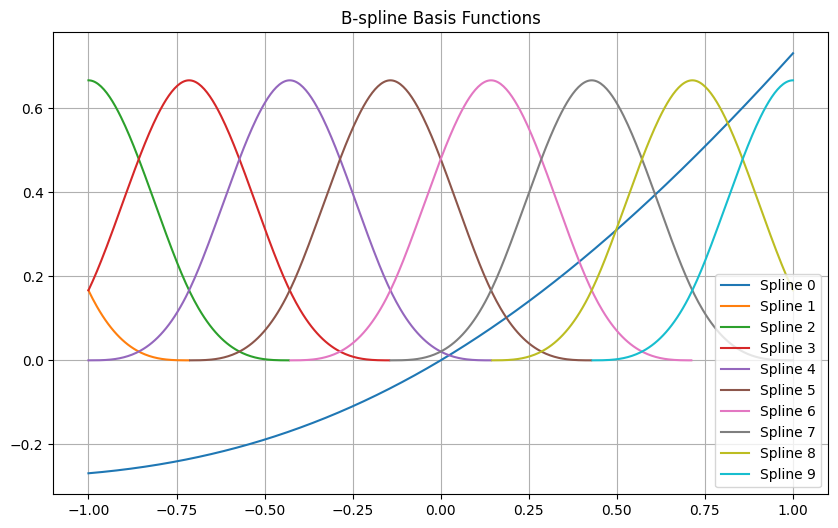

In [209]:
x_bounds = (-1, 1)
n_fun = 10
degree = 3

edge_fun, edge_fun_der = get_bsplines(x_bounds, n_fun, degree)

x_vals = np.linspace(x_bounds[0], x_bounds[1], 500)
plt.figure(figsize=(10, 6))
for key, func in edge_fun.items():
    if callable(func):  
        y_vals = func(x_vals)
        plt.plot(x_vals, y_vals, label=f"Spline {key}")

plt.title("B-spline Basis Functions")
plt.legend()
plt.grid(True)
plt.show()

In [210]:
class NeuronKAN(Neuron):
    def __init__(self, n_in, n_weights_per_edge, x_bounds, weights_range=None, get_edge_fun=get_bsplines, **kwargs):
        self.x_bounds = x_bounds
        super().__init__(n_in, n_weights_per_edge=n_weights_per_edge, weights_range=weights_range)
        self.edge_fun, self.edge_fun_der = get_edge_fun(self.x_bounds, self.n_weights_per_edge, **kwargs)
 
    def get_xmid(self):
        self.phi_x_mat = np.array([self.edge_fun[b](self.xin) for b in self.edge_fun]).T
        self.phi_x_mat[np.isnan(self.phi_x_mat)] = 0
        self.xmid = (self.weights * self.phi_x_mat).sum(axis=1)
 
    def get_xout(self):
        self.xout = tanh_act(sum(self.xmid.flatten()), get_derivative=False)
 
    def get_dxout_dxmid(self):
        self.dxout_dxmid = tanh_act(sum(self.xmid.flatten()), get_derivative=True) * np.ones(self.n_in)
 
    def get_dxmid_dw(self):
        self.dxmid_dw = self.phi_x_mat
 
    def get_dxmid_dxin(self):
        phi_x_der_mat = np.array([self.edge_fun_der[b](self.xin) if self.edge_fun[b](self.xin) is not None else 0
                                  for b in self.edge_fun_der]).T  
        phi_x_der_mat[np.isnan(phi_x_der_mat)] = 0
        self.dxmid_dxin = (self.weights * phi_x_der_mat).sum(axis=1)
 
    def get_dxout_dbias(self):
        self.dxout_dbias = 0
        

In [211]:
class FullyConnectedLayer:
    def __init__(self, n_in, n_out, neuron_class=NeuronNN, **kwargs):
        self.n_in, self.n_out = n_in, n_out
        self.neurons = [neuron_class(n_in) if (kwargs == {}) else neuron_class(n_in, **kwargs) for _ in range(n_out)]
        self.xin = None  
        self.xout = None  
        self.dloss_dxin = None  
        self.zero_grad()
 
    def __call__(self, xin):   
        self.xin = xin
        self.xout = np.array([nn(self.xin) for nn in self.neurons])
        return self.xout
 
    def zero_grad(self, which=None):   
        if which is None:
            which = ['xin', 'weights', 'bias']
        for w in which:
            if w == 'xin':  
                self.dloss_dxin = np.zeros(self.n_in)
            elif w == 'weights':  
                for nn in self.neurons:
                    nn.dloss_dw = np.zeros((self.n_in, self.neurons[0].n_weights_per_edge))
            elif w == 'bias':  
                for nn in self.neurons:
                    nn.dloss_dbias = 0
            else:
                raise ValueError('input \'which\' value not recognized')
 
    def update_grad(self, dloss_dxout):    
        for ii, dloss_dxout_tmp in enumerate(dloss_dxout):       
            self.dloss_dxin += self.neurons[ii].dxout_dxin * dloss_dxout_tmp     
            self.neurons[ii].update_dloss_dw_dbias(dloss_dxout_tmp)
        return self.dloss_dxin
    

In [212]:
class Loss:
    def __init__(self, n_in):
        self.n_in = n_in
        self.y, self.dloss_dy, self.loss, self.y_train = None, None, None, None
 
    def __call__(self, y, y_train):
        self.y, self.y_train = np.array(y), y_train
        self.get_loss()
        self.get_dloss_dy()
        return self.loss
 
    def get_loss(self):
        pass
 
    def get_dloss_dy(self): 
        pass
 
 
class SquaredLoss(Loss):
    def get_loss(self): 
        self.loss = np.mean(np.power(self.y - self.y_train, 2))
 
    def get_dloss_dy(self): 
        self.dloss_dy = 2 * (self.y - self.y_train) / self.n_in
 
 
class CrossEntropyLoss(Loss):
    def get_loss(self): 
        self.loss = - np.log(np.exp(self.y[self.y_train[0]]) / sum(np.exp(self.y)))
 
    def get_dloss_dy(self): 
        self.dloss_dy = np.exp(self.y) / sum(np.exp(self.y))
        self.dloss_dy[self.y_train] -= 1

In [213]:
from tqdm import tqdm
 
class FeedForward:
    def __init__(self, layer_len, eps=.0001, seed=None, loss=SquaredLoss, **kwargs):
        self.seed = np.random.randint(int(1e4)) if seed is None else int(seed)
        np.random.seed(self.seed)
        self.layer_len = layer_len
        self.eps = eps
        self.n_layers = len(self.layer_len) - 1
        self.layers = [FullyConnectedLayer(layer_len[ii], layer_len[ii + 1], **kwargs) for ii in range(self.n_layers)]
        self.loss = loss(self.layer_len[-1])
        self.loss_hist = None
 
    def __call__(self, x):
        x_in = x
        for ll in range(self.n_layers):
            x_in = self.layers[ll](x_in)
        return x_in
 
    def backprop(self):
        delta = self.layers[-1].update_grad(self.loss.dloss_dy)
        for ll in range(self.n_layers - 1)[::-1]:
            delta = self.layers[ll].update_grad(delta)
 
    def gradient_descent_par(self):
        for ll in self.layers:
            for nn in ll.neurons:
                nn.gradient_descent(self.eps)
 
    def train(self, x_train, y_train, n_iter_max=10000, loss_tol=.1):
        self.loss_hist = np.zeros(n_iter_max)
        x_train, y_train = np.array(x_train), np.array(y_train)
        assert x_train.shape[0] == y_train.shape[0], 'x_train, y_train must contain the same number of samples'
        assert x_train.shape[1] == self.layer_len[0], 'shape of x_train is incompatible with first layer'
 
        pbar = tqdm(range(n_iter_max))
        for it in pbar:
            loss = 0  
            for ii in range(x_train.shape[0]):
                x_out = self(x_train[ii, :])  
                loss += self.loss(x_out, y_train[ii, :])  
                self.backprop()  
                [layer.zero_grad(which=['xin']) for layer in self.layers]  
            self.loss_hist[it] = loss
            if (it % 10) == 0:
                pbar.set_postfix_str(f'loss: {loss:.9f}')  
            if loss < loss_tol:
                pbar.set_postfix_str(f'loss: {loss:.9f}. Convergence has been attained!')
                self.loss_hist = self.loss_hist[: it]
                break
            self.gradient_descent_par()  
            [layer.zero_grad(which=['weights', 'bias']) for layer in self.layers]  


In [214]:
n_iter_train_1d = 7500
loss_tol_1d = .05
seed = 476
 
x_train = np.linspace(-1, 1, 5).reshape(-1, 1)
y_train = .5 * x_train**3
 

kan_1d = FeedForward([1, 13, 1],  
                  eps=.01,  
                  n_weights_per_edge=7,  
                  neuron_class=NeuronKAN, 
                  x_bounds=[-1, 1],  
                  get_edge_fun=get_bsplines,  
                  seed=seed,
                  weights_range=[-1, 1])
kan_1d.train(x_train, 
          y_train, 
          n_iter_max=n_iter_train_1d, 
          loss_tol=loss_tol_1d)
 

mlp_1d = FeedForward([1, 13, 1],  
                  eps=.005,  
                  activation=tanh_act,  
                  neuron_class=NeuronNN, 
                  seed=seed,
                  weights_range=[-.5, .5])
mlp_1d.train(x_train, 
             y_train, 
             n_iter_max=n_iter_train_1d, 
             loss_tol=loss_tol_1d)


  0%|          | 0/7500 [00:00<?, ?it/s]

 95%|█████████▌| 7160/7500 [00:18<00:00, 392.97it/s, loss: 0.049992051. Convergence has been attained!]


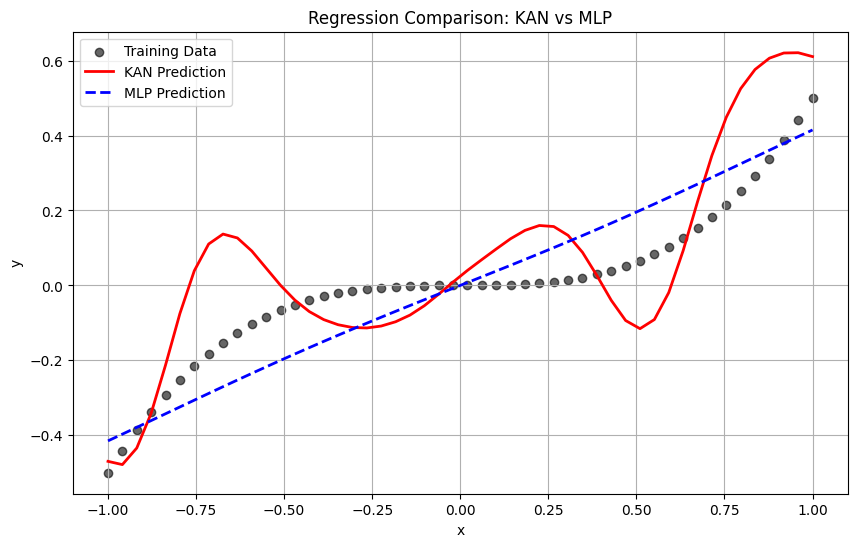

In [215]:
x_test = np.linspace(-1, 1, 50).reshape(-1, 1)
y_test = .5  * x_test**3
y_kan = np.array([kan_1d(x) for x in x_test])
y_mlp = np.array([mlp_1d(x) for x in x_test])

plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, color='black', label='Training Data', alpha=0.6)
plt.plot(x_test, y_kan, 'r-', label='KAN Prediction', linewidth=2)
plt.plot(x_test, y_mlp, 'b--', label='MLP Prediction', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regression Comparison: KAN vs MLP')
plt.legend()
plt.grid(True)
plt.show()